# Title

In [12]:
# Cell 1
import pandas as pd

# Cell 2
df = pd.read_csv("../data/filtered_700_April.csv")
df.head()


,Timestamp,Distance_mm
0,2025-04-04 13:43:03,1231
1,2025-04-04 13:43:17,738
2,2025-04-04 13:43:32,1103
3,2025-04-04 15:42:06,700
4,2025-04-04 15:43:56,845


### Graph 1

### Graph 2

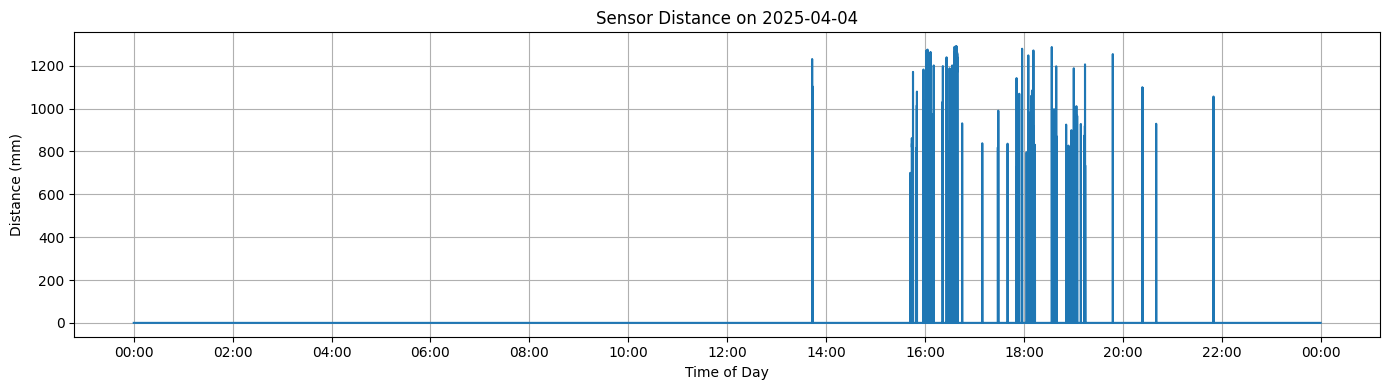

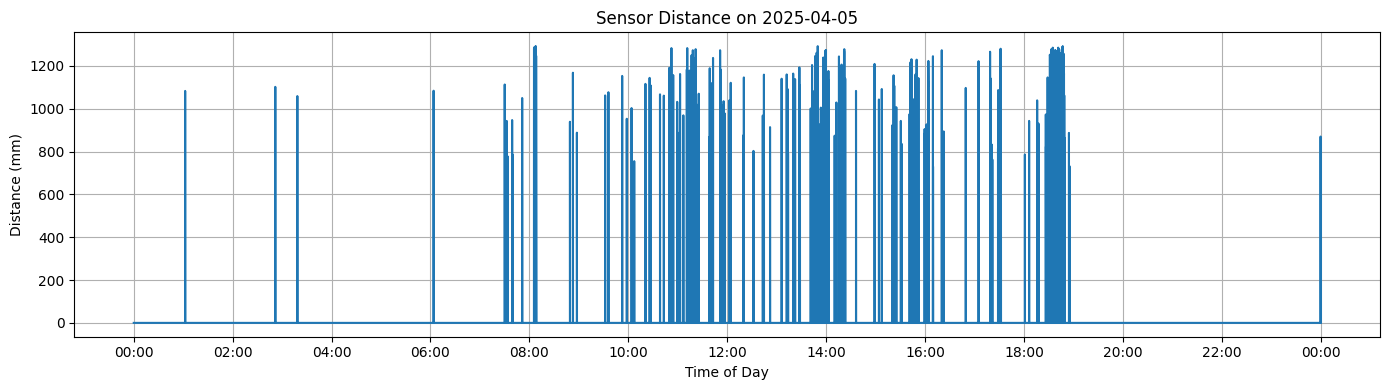

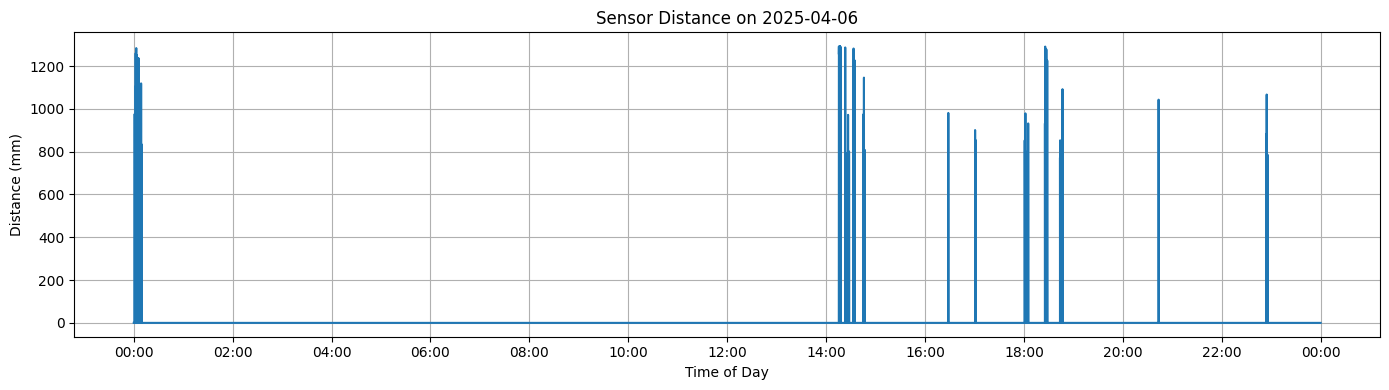

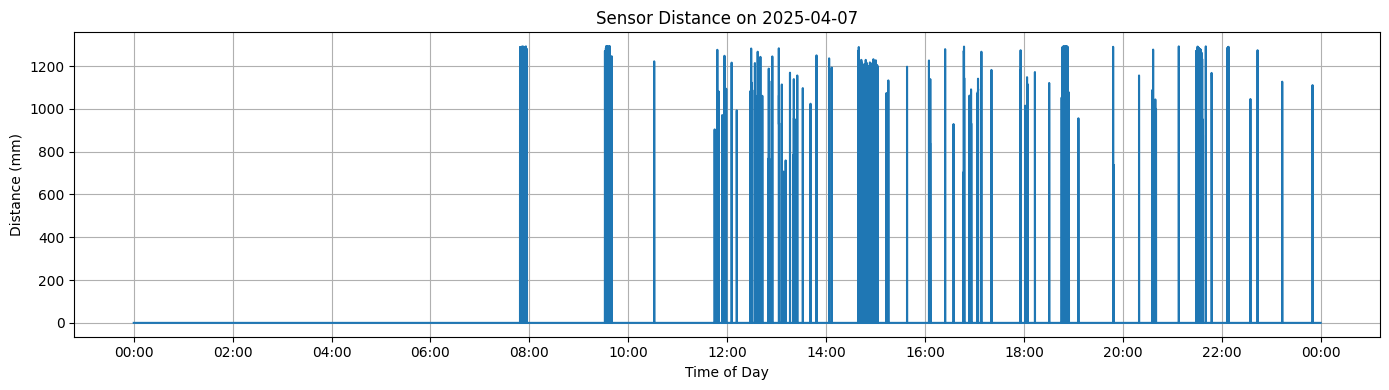

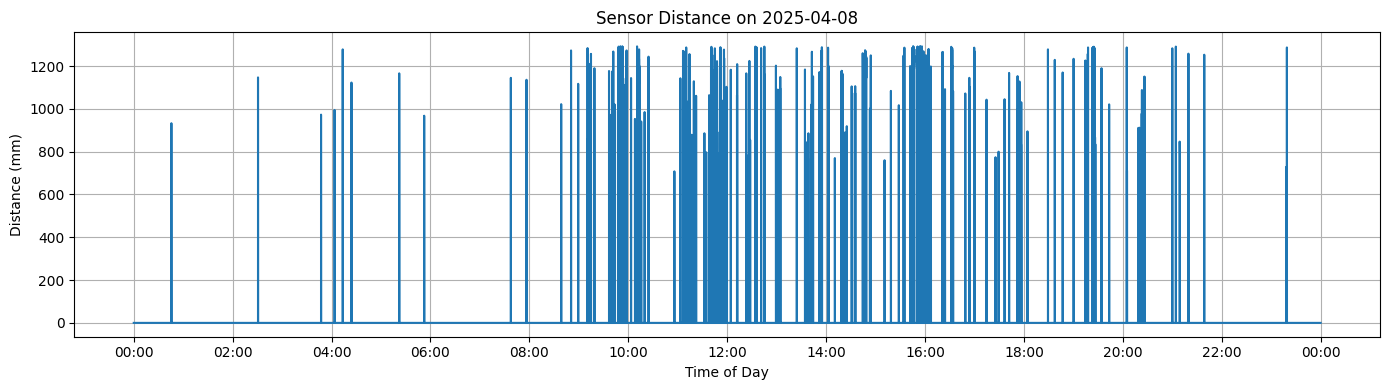

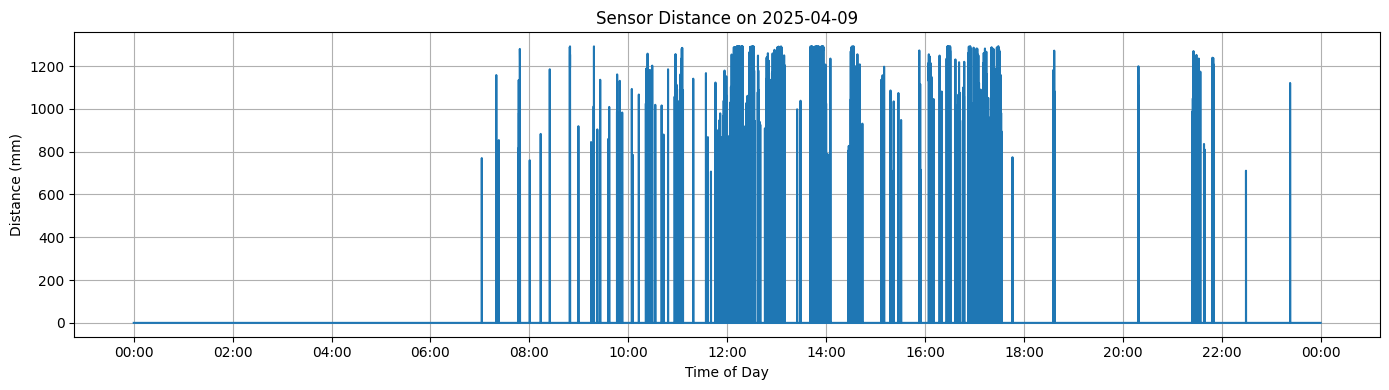

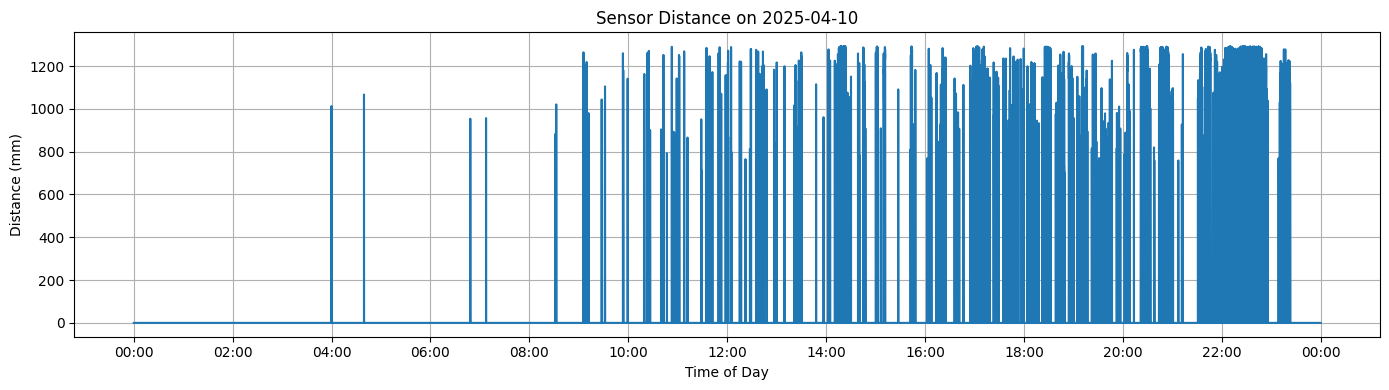

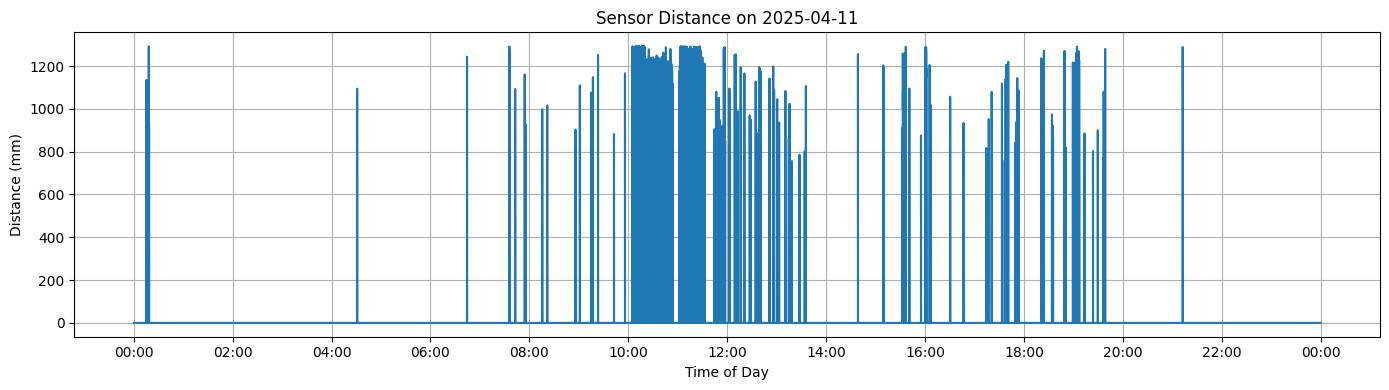

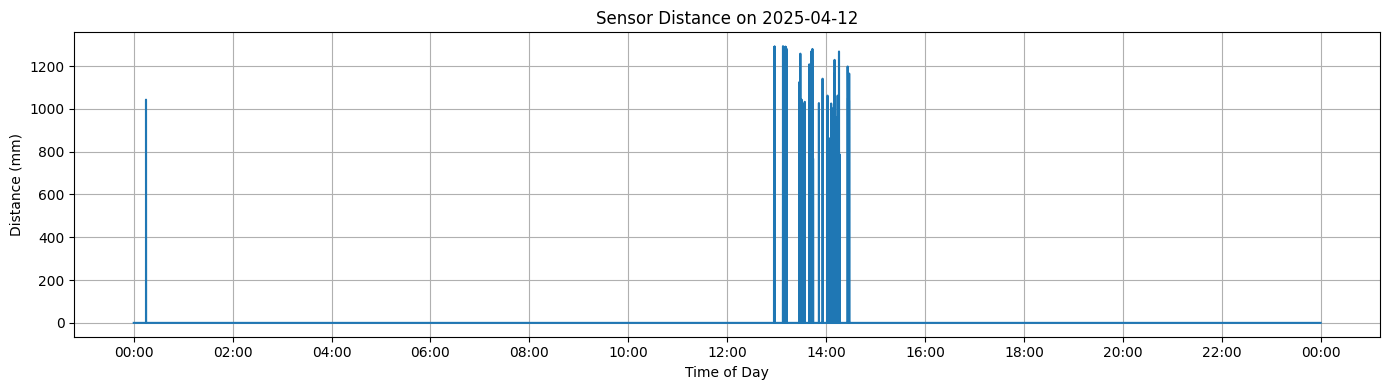

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Date'] = df['Timestamp'].dt.date

# Group by date
grouped = df.groupby('Date')

for date, group in grouped:
    # Round timestamps down to the second
    group['RoundedTime'] = group['Timestamp'].dt.floor('s')

    # Aggregate to one value per second
    per_second = group.groupby('RoundedTime')['Distance_mm'].max()

    # Create full second-by-second range for the day
    time_index = pd.date_range(start=f"{date} 00:00:00", end=f"{date} 23:59:59", freq='s')

    # Reindex to include all seconds, fill missing with 0
    full_series = per_second.reindex(time_index, fill_value=0)

    # Plot using datetime x-axis
    plt.figure(figsize=(14, 4))
    plt.plot(full_series.index, full_series.values)

    # Format x-axis to show time of day every 6 hours
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=2))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    plt.xlabel("Time of Day")
    plt.ylabel("Distance (mm)")
    plt.title(f"Sensor Distance on {date}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



## Create ML Data sets

In [16]:
# Ensure data is sorted by time
df = df.sort_values('Timestamp').reset_index(drop=True)

# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15  # (or just 1 - train_ratio - val_ratio)

# Compute split indices
n = len(df)
train_end = int(n * train_ratio)
val_end = train_end + int(n * val_ratio)

# Slice the DataFrame
df_train = df.iloc[:train_end].copy()
df_val = df.iloc[train_end:val_end].copy()
df_test = df.iloc[val_end:].copy()

df_train.to_csv("out/train.csv", index=False)
df_val.to_csv("out/val.csv", index=False)
df_test.to_csv("out/test.csv", index=False)


## Model 2 

MAE: 23.92
MSE: 8516.56
R²: -0.04


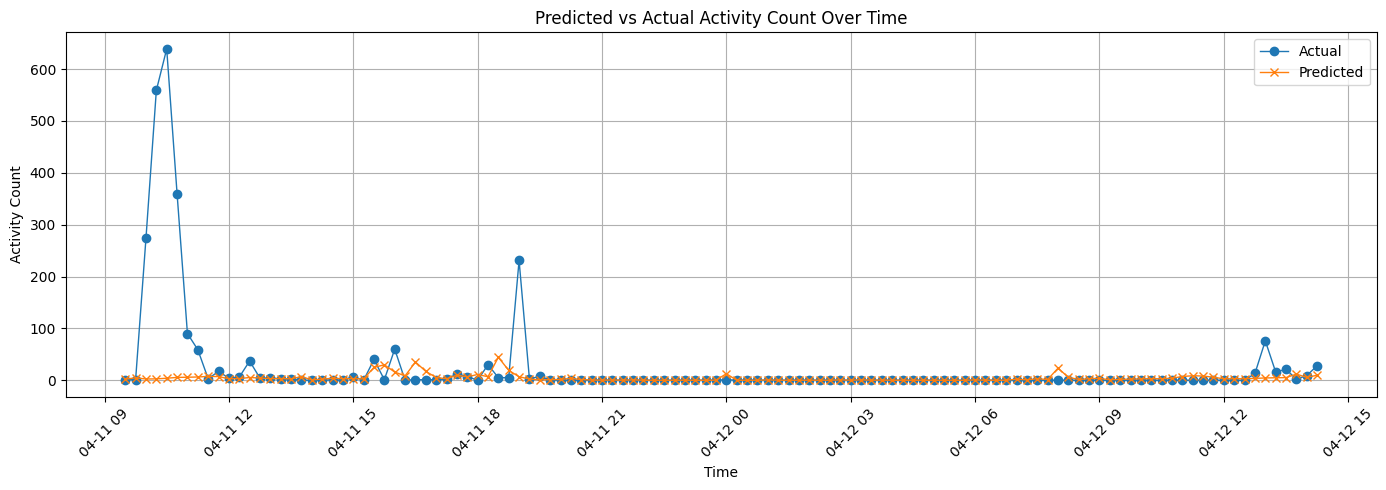

In [18]:
df.reset_index(drop=True, inplace=True)

df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

# Count events per 15-minute window
activity = df.resample('15min').size().rename("Activity_Count").reset_index()

activity['Hour'] = activity['Timestamp'].dt.hour
activity['Minute'] = activity['Timestamp'].dt.minute
activity['DayOfWeek'] = activity['Timestamp'].dt.dayofweek  # 0 = Monday
activity['Weekend'] = activity['DayOfWeek'] >= 5


from sklearn.ensemble import RandomForestRegressor

features = ['Hour', 'Minute', 'DayOfWeek', 'Weekend']
X = activity[features]
y = activity['Activity_Count']

# Use your same train/val/test split logic here
model = RandomForestRegressor()
model.fit(X, y)

from sklearn.model_selection import train_test_split


X = activity[['Hour', 'DayOfWeek', 'Minute', 'Weekend']]
y = activity['Activity_Count']

# First split: train vs temp (val + test)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, shuffle=False)
# Why 0.176? Because 0.15 / 0.85 ≈ 0.176 — keeps val 15%, test 15%, train 70%

# Combine features and labels before saving
train_df = X_train.copy()
train_df['Activity_Count'] = y_train

val_df = X_val.copy()
val_df['Activity_Count'] = y_val

test_df = X_test.copy()
test_df['Activity_Count'] = y_test

# Export
train_df.to_csv("activity_train.csv", index=False)
val_df.to_csv("activity_val.csv", index=False)
test_df.to_csv("activity_test.csv", index=False)


from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R²: {r2:.2f}")

df.reset_index(inplace=True)

timestamps = activity['Timestamp']
timestamps_test = timestamps.iloc[X_test.index]

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(timestamps_test, y_test.values, label='Actual', marker='o', linewidth=1)
plt.plot(timestamps_test, y_pred, label='Predicted', marker='x', linewidth=1)
plt.xlabel("Time")
plt.ylabel("Activity Count")
plt.title("Predicted vs Actual Activity Count Over Time")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [19]:
import ipywidgets as widgets
from IPython.display import display
from datetime import datetime

date_picker = widgets.DatePicker(description='Select Date')
hour_slider = widgets.IntSlider(min=0, max=23, description='Hour')
minute_slider = widgets.IntSlider(min=0, max=59, step=15, description='Minute')

def forecast_activity(date, hour, minute):
    if date is None:
        print("Select a date.")
        return

    ts = pd.Timestamp(datetime.combine(date, datetime.min.time())) + pd.Timedelta(hours=hour, minutes=minute)

    # Define features in the exact order used during training
    features = pd.DataFrame([[
        ts.hour,
        ts.dayofweek,
        ts.minute,
        ts.dayofweek >= 5
    ]], columns=['Hour', 'DayOfWeek', 'Minute', 'Weekend'])


    pred = model.predict(features)[0]
    print(f"📅 Prediction for {ts.strftime('%Y-%m-%d %H:%M')}: {pred:.0f} detections")

ui = widgets.VBox([date_picker, hour_slider, minute_slider])
out = widgets.interactive_output(forecast_activity, {
    'date': date_picker,
    'hour': hour_slider,
    'minute': minute_slider
})

display(ui, out)


Output()

## Model 3 - Gradient boosted tree

Exported 'full_aggregated_data.csv' with all rows, new features, and a 'mod7' column.
Total rows:      1157
Train rows:      825  (~71.3%)
Validation rows: 166    (~14.3%)
Test rows:       166    (~14.3%)

Exported 'train_data.csv', 'val_data.csv', 'test_data.csv'.

Validation Metrics (Approx 15% of data):
MAE: 13.70
MSE: 1669.43
R² : 0.15

Test Metrics (Approx 15% of data):
MAE: 14.93
MSE: 2259.89
R² : 0.15


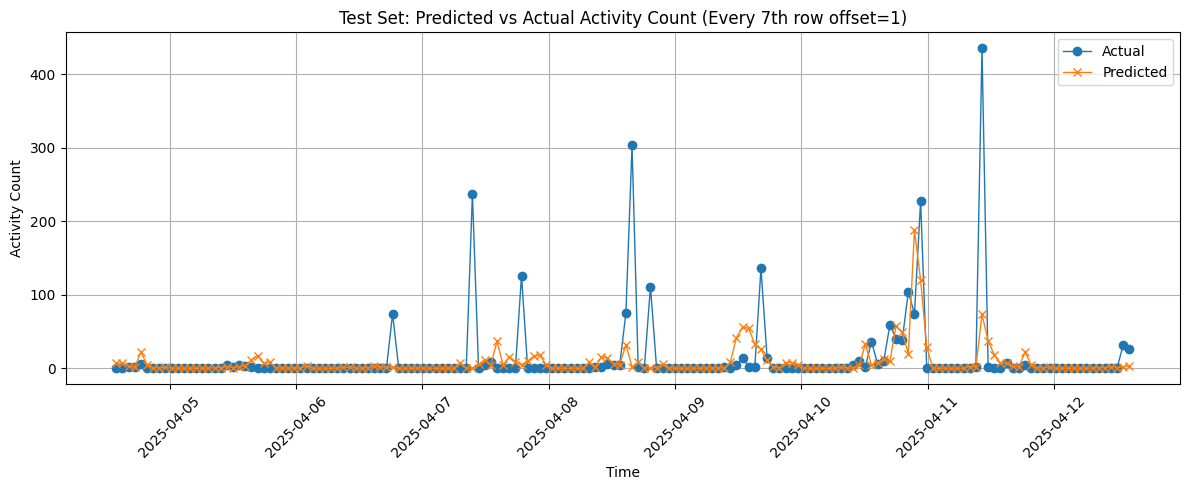


Model saved to 'output_model.pkl'.


Output()

In [21]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib

# UI imports
import ipywidgets as widgets
from IPython.display import display
from datetime import datetime

# ----------------------------------
# 1) LOAD & PREP YOUR DATA
# ----------------------------------
df = pd.read_csv("../data/filtered_700_April.csv")
df.reset_index(drop=True, inplace=True)

df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

# Resample in 10-minute windows and count rows
activity = df.resample('10min').size().rename("Activity_Count").reset_index()

# (NEW) Instead of 'ID', add a 'mod7' column
activity['mod7'] = np.arange(len(activity)) % 7

# Create time-based features
activity['Hour'] = activity['Timestamp'].dt.hour
activity['Minute'] = activity['Timestamp'].dt.minute
activity['DayOfWeek'] = activity['Timestamp'].dt.dayofweek
activity['Weekend'] = activity['DayOfWeek'] >= 5

# (NEW) Export the full aggregated dataset (100% of rows) to CSV
activity.to_csv("full_aggregated_data.csv", index=False)
print("Exported 'full_aggregated_data.csv' with all rows, new features, and a 'mod7' column.")

# Define features/target
features = ['Hour', 'Minute', 'DayOfWeek', 'Weekend']
X = activity[features]
y = activity['Activity_Count']

# ----------------------------------
# 2) SPLIT DATA INTO TRAIN, VAL, TEST (~70%, ~15%, ~15%)
#    Using the same cyclical approach for Python-based splitting
indices = np.arange(len(X))
val_inds = indices[::7]
test_inds = indices[1::7]
both = np.union1d(val_inds, test_inds)
train_inds = np.setdiff1d(indices, both)

print(f"Total rows:      {len(X)}")
print(f"Train rows:      {len(train_inds)}  (~{100*len(train_inds)/len(X):.1f}%)")
print(f"Validation rows: {len(val_inds)}    (~{100*len(val_inds)/len(X):.1f}%)")
print(f"Test rows:       {len(test_inds)}    (~{100*len(test_inds)/len(X):.1f}%)")

# 3) CREATE TRAIN/VAL/TEST DATA
X_train = X.iloc[train_inds]
y_train = y.iloc[train_inds]

X_val   = X.iloc[val_inds]
y_val   = y.iloc[val_inds]

X_test  = X.iloc[test_inds]
y_test  = y.iloc[test_inds]

# Export subsets (including Timestamp, Activity_Count, mod7, etc.)
train_df = activity.iloc[train_inds].copy()
val_df   = activity.iloc[val_inds].copy()
test_df  = activity.iloc[test_inds].copy()

train_df.to_csv("train_data.csv", index=False)
val_df.to_csv("val_data.csv", index=False)
test_df.to_csv("test_data.csv", index=False)
print("\nExported 'train_data.csv', 'val_data.csv', 'test_data.csv'.")

# ----------------------------------
# 4) TRAIN A GRADIENT BOOSTED TREE
# ----------------------------------
model = HistGradientBoostingRegressor(loss="poisson")  
model.fit(X_train, y_train)

# ----------------------------------
# 5) VALIDATION PHASE
# ----------------------------------
y_val_pred = model.predict(X_val)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2  = r2_score(y_val, y_val_pred)

print("\nValidation Metrics (Approx 15% of data):")
print(f"MAE: {val_mae:.2f}")
print(f"MSE: {val_mse:.2f}")
print(f"R² : {val_r2:.2f}")

# ----------------------------------
# 6) TEST PHASE
# ----------------------------------
y_test_pred = model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2  = r2_score(y_test, y_test_pred)

print("\nTest Metrics (Approx 15% of data):")
print(f"MAE: {test_mae:.2f}")
print(f"MSE: {test_mse:.2f}")
print(f"R² : {test_r2:.2f}")

# ----------------------------------
# 7) PLOT TEST RESULTS
# ----------------------------------
timestamps_test = activity['Timestamp'].iloc[test_inds]

plt.figure(figsize=(12, 5))
plt.plot(timestamps_test, y_test.values, label='Actual', marker='o', linewidth=1)
plt.plot(timestamps_test, y_test_pred, label='Predicted', marker='x', linewidth=1)
plt.xlabel("Time")
plt.ylabel("Activity Count")
plt.title("Test Set: Predicted vs Actual Activity Count (Every 7th row offset=1)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------------------------
# 8) SAVE THE MODEL
# ----------------------------------
joblib.dump(model, "output_model.pkl")
print("\nModel saved to 'output_model.pkl'.")

# ----------------------------------
# 9) CREATE UI
# ----------------------------------
date_picker = widgets.DatePicker(description='Select Date')
hour_slider = widgets.IntSlider(min=0, max=23, description='Hour')
minute_slider = widgets.IntSlider(min=0, max=59, step=15, description='Minute')

def forecast_activity(date, hour, minute):
    if date is None:
        print("Select a date.")
        return
    
    ts = pd.Timestamp(datetime.combine(date, datetime.min.time())) \
         + pd.Timedelta(hours=hour, minutes=minute)

    # EXACT ORDER & NAMES MUST MATCH TRAINING
    feats = pd.DataFrame([[
        ts.hour,
        ts.minute,
        ts.dayofweek,
        ts.dayofweek >= 5
    ]],
    columns=['Hour', 'Minute', 'DayOfWeek', 'Weekend'])

    prediction = model.predict(feats)[0]
    print(f"📅 Prediction for {ts.strftime('%Y-%m-%d %H:%M')}: {prediction:.0f} detections")

out = widgets.interactive_output(
    forecast_activity,
    {'date': date_picker, 'hour': hour_slider, 'minute': minute_slider}
)

ui = widgets.VBox([date_picker, hour_slider, minute_slider])
display(ui, out)
